# Restitching Long Term Atrial Fibrillation Database
Sections you'll find in this notebook:
1. Collecting original [ltafdb annotations](https://physionet.org/content/ltafdb/1.0.0/) and stitching them together
1. Analysis of stitched episodes for both sinus and atrial fibrillation
1. Common dataset definition

## 1. Collecting original ltafdb annotations and stitching them together

In [4]:
# Load patient data and individual annotations
import datetime as dt
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm

from joblib import Memory

## pls excuse
import os, sys
up1 = os.path.abspath('..'); sys.path.insert(0, up1)
## pls excuse

from prediction import loadData as data

# redefine for your data location
DATA_DIR = Path(os.getcwd()).parent  / 'data' / 'assets' / 'europace' / 'physionet.org/files/ltafdb/1.0.0'
# stitching parameters
STITCH_LENGTH_SECONDS=10 #if end of annotation exceeds
def collectAllRhythmsWithinStitch(rhythm='(AFIB', stitch_length = dt.timedelta(seconds=5)):
    global DATA_DIR, CACHED
    allIDs = data.getAllRecordIDs(europaceDownloadDir=DATA_DIR)
    result = list()
    for id in tqdm(allIDs, total=len(allIDs)):
        #collect all afib annotations for patient
        annotationsForPatient: pd.DataFrame = data.getRhythmAnnotations(id, rhythmToCollect=rhythm, searchDir=DATA_DIR)
        #stitch baby
        annotationsForPatient.sort_values(by='start', inplace=True)
        preStitched = annotationsForPatient.copy()
        postStitched = {
            'start': list(),
            'stop': list(),
            'id': list(),
            'basetime': list()
        }
        i = 0
        broke=False
        while (i < len(annotationsForPatient)):
            knitStart = annotationsForPatient.iloc[i, :]['start']
            knitStop = curStop = annotationsForPatient.iloc[i, :]['stop']
            if (i+1 >= len(annotationsForPatient)):
                broke=True
                break
            nextStart = annotationsForPatient.iloc[i+1, :]['start']
            while ((nextStart - curStop) < stitch_length):
                i += 1
                if (i+1 >= len(annotationsForPatient)):
                    broke=True
                    break
                knitStop = curStop = annotationsForPatient.iloc[i, :]['stop']
                nextStart = annotationsForPatient.iloc[i+1, :]['start']
            #time to add entry as a post stitched episode
            postStitched['start'].append(knitStart)
            postStitched['stop'].append(knitStop)
            postStitched['id'].append(id)
            postStitched['basetime'].append(annotationsForPatient.iloc[i-1, :]['basetime'])
            i+=1
        if (broke):
            #time to add entry as a post stitched episode
            postStitched['start'].append(knitStart)
            postStitched['stop'].append(knitStop)
            postStitched['id'].append(id)
            postStitched['basetime'].append(annotationsForPatient.iloc[i-1, :]['basetime'])
        result.append(pd.DataFrame(postStitched))

    return pd.concat(result)
stitchedAnnotations_10sec = collectAllRhythmsWithinStitch(stitch_length=dt.timedelta(seconds=10))
stitchedAnnotations_5sec = collectAllRhythmsWithinStitch(stitch_length=dt.timedelta(seconds=5))
stitchedAnnotations_1sec = collectAllRhythmsWithinStitch(stitch_length=dt.timedelta(seconds=1))

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

In [5]:

from prediction.loadData import getRhythmAnnotations, getAllRecordIDs

# utility functions defined for dataframe of annotations, should you wish to analyze:
# - uniquePatients(df), numberOfEvents(df), filterAnnotationsByLength(df, length)
## i.e., print(uniquePatients(filtered), numberOfEvents(filterAnnotationsByLength(filtered, length=dt.timedelta(seconds=60))))
uniquePatients = lambda df: len(df['id'].unique())
numberOfEvents = lambda df: len(df)
def filterAnnotationsByLength(df, length = dt.timedelta(seconds=30)):
    return df[(df['stop']-df['start']) > length]

allIdsRaw = list()
for id in getAllRecordIDs():
    allIdsRaw.append(getRhythmAnnotations(id))
raw_ltafdb_annotations = pd.concat(allIdsRaw)


## 2. Analysis of stitched episodes for both sinus and atrial fibrillation

### 2.1 What proportion of stitched annotations were originally annotated as atrial fibrillation?

In [6]:
# Sydney sync:
## even if our annotation extractions are correct, it seems like some annotations (i.e. changing a rhythm 3 times in a second?) are implausible
## proportion of time the annotation says during a stitch difference --> over 50% necessary, higher is better
## patient_id, start, end, start1, end1,
import pandas as pd
def proportionOfStitchedEpisodesInAfib(stitchedAnnotations: pd.DataFrame, rawAnnotations: pd.DataFrame):
    rawAnnotationsWithinStitch = lambda df: rawAnnotations[(df['id'] == rawAnnotations['id']) & (df['start'] <= rawAnnotations['start']) & (rawAnnotations['stop'] <= df['stop'])]
    runRawSum = dt.timedelta(seconds=0)
    runStitchSum = dt.timedelta(seconds=0)
    for i, annotation in stitchedAnnotations.iterrows():
        runStitchSum += annotation['stop'] - annotation['start']
        #collect corresponding rawAnnotations and sum their durations
        correspondingRawAnnotations = rawAnnotationsWithinStitch(annotation)
        for i, rawAnn in correspondingRawAnnotations.iterrows():
            runRawSum += rawAnn['stop'] - rawAnn['start']
    return runRawSum / runStitchSum
proportion_10sec = proportionOfStitchedEpisodesInAfib(stitchedAnnotations_10sec, raw_ltafdb_annotations)
proportion_5sec =  proportionOfStitchedEpisodesInAfib(stitchedAnnotations_5sec, raw_ltafdb_annotations)
proportion_1sec =  proportionOfStitchedEpisodesInAfib(stitchedAnnotations_1sec, raw_ltafdb_annotations)

proportion_10sec, proportion_5sec, proportion_1sec

(0.9927837261435982, 0.9964048754998002, 0.9999749746928365)

### 2.2 What proportion of sinus stitched annotations were originally annotated as sinus rhythm?

In [7]:
#collect pure sinus portions for patients
stitchedSinus_10sec = collectAllRhythmsWithinStitch(rhythm='(N', stitch_length=dt.timedelta(seconds=10))
rawSinus = pd.concat([getRhythmAnnotations(id, rhythmToCollect='(N') for id in getAllRecordIDs(europaceDownloadDir=DATA_DIR)])
sinusProportion = proportionOfStitchedEpisodesInAfib(stitchedSinus_10sec, rawSinus)
sinusProportion
# def parseAnnotationsIntoCommonDataFormat(duty_cycle: dt.timedelta = dt.timedelta(hours=2)):

  0%|          | 0/84 [00:00<?, ?it/s]

0.9695075776226012

### 2.3 What is the distribution of episode lengths, after stitching?

Text(0.5, 0, 'Duration (hours)')

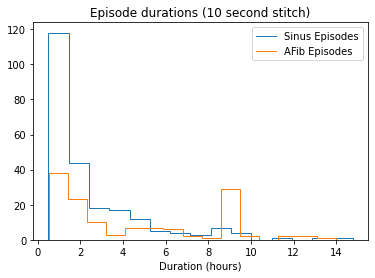

In [8]:
# sinusProportion, numberOfEvents(stitchedSinus_10sec), len(filterAnnotationsByLength(stitchedSinus_10sec, dt.timedelta(hours=2)))
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
# set sliders as you please
ignoreEpisodesShorterThan = dt.timedelta(minutes=30)
numBins = 15

#calculate durations
stitchedAfib_10sec = stitchedAnnotations_10sec
stitchedAfib_10sec['duration_hr'] = (stitchedAfib_10sec['stop'] - stitchedAfib_10sec['start']).apply(lambda x: x.total_seconds() / 60 / 60)
stitchedSinus_10sec['duration_hr'] = (stitchedSinus_10sec['stop'] - stitchedSinus_10sec['start']).apply(lambda x: x.total_seconds() / 60 / 60)

#plot histograms
counts, bins = np.histogram(filterAnnotationsByLength(stitchedSinus_10sec, length=ignoreEpisodesShorterThan)['duration_hr'], bins=numBins)
plt.stairs(counts, bins, label="Sinus Episodes")
counts, bins = np.histogram(filterAnnotationsByLength(stitchedAfib_10sec, length=ignoreEpisodesShorterThan)['duration_hr'], bins=numBins)
plt.stairs(counts, bins, label="AFib Episodes")
plt.title("Episode durations (10 second stitch)")
plt.legend(); plt.xlabel('Duration (hours)')


### 2.4 Patient signal visualizer
Incomplete - overlay of stitched and perhaps also unstitched annotations would be more informative

In [ ]:

from matplotlib.animation import FuncAnimation
%matplotlib notebook
stitchedAfib_10sec['rhythm'] = 'sinus'
stitchedSinus_10sec['rhythm'] = 'atrial_fibrillation'
stitchedAnnotations = pd.concat([stitchedAfib_10sec, stitchedSinus_10sec])
stitchedAnnotations.sort_values(by=['id', 'start'], inplace=True)

def getSlice(id: str, start: dt.datetime, stop: dt.datetime, src) -> np.array:
    record, _ = data.getRecordByID(id, searchDir=src)
    recordBaseTime: dt.datetime = record.base_datetime
    samplingRate: int = record.fs

    startIdx, endIdx = (start - recordBaseTime).total_seconds()*samplingRate, (stop - recordBaseTime).total_seconds()*samplingRate
    startIdx, endIdx = int(startIdx), int(endIdx)
    return record.p_signal[startIdx:endIdx, 0]
## see [here](https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389) for animation code I copy below
# Enable interactive plot

## setting animation parameters
FRAME_DURATION_S = 15 #seconds
INTERVAL_BETWEEN_FRAMES_MS = 80 #milliseconds

##
df = stitchedAnnotations[stitchedAnnotations['id'] == '00']
def visualizePatient(df: pd.DataFrame):
    df = df.sort_values(by=['start'])
    #start of first episode, and end of last episode will mark our bounds for plotting
    id = df.iloc[0, :]['id']
    samplerate = data.getHeaderById(id, DATA_DIR).fs
    sigStart, sigStop = df.iloc[0, :]['start'], df.iloc[-1, :]['stop']
    slice = getSlice(id, sigStart, sigStop, DATA_DIR)
    fig, ax = plt.subplots(figsize=(12, 4))
    line, = ax.plot([])
    ax.set_ylim(-1.1, 1.1)
    def animate(frameNum):
        #ith frame should show i increments of interval between ms from the start, to frame_duration_s at end
        start = int(frameNum*INTERVAL_BETWEEN_FRAMES_MS/1000 * samplerate)
        stop = start + int(FRAME_DURATION_S*samplerate)
        ySlice = slice[start:stop]
        # print(ySlice)
        startTime, stopTime = sigStart + dt.timedelta(milliseconds=int(start/samplerate * 1000)), sigStart + dt.timedelta(milliseconds=int(stop/samplerate * 1000))
        # print(startTime, stopTime)
        xs = pd.date_range(start=startTime, end=stopTime, periods=len(ySlice)).to_numpy()#np.linspace(startTime, stopTime, len(ySlice))
        # line.set_data((np.linspace(0, 6, len(ySlice)), ySlice))
        ax.set_xlim(startTime, stopTime)
        line.set_data((xs, ySlice))
        return line
    numFrames = int((sigStop - sigStart).total_seconds() * 1000 / INTERVAL_BETWEEN_FRAMES_MS) # for whole signal
    numFrames = 200
    anim = FuncAnimation(fig, animate, frames=2000, interval=INTERVAL_BETWEEN_FRAMES_MS)
    print(f'Now showing first {numFrames * INTERVAL_BETWEEN_FRAMES_MS / 1000 // 60} minutes of signal, from time {sigStart}')

    return anim

anim = visualizePatient(stitchedAnnotations[stitchedAnnotations['id'] == '00'])
from IPython.display import HTML
HTML(anim.to_html5_video())

                        start                        stop  id  \
0  2003-01-31 09:40:53.179688  2003-01-31 18:36:37.375000  00   
0  2003-01-31 19:30:39.445312  2003-01-31 19:34:15.007812  00   
1  2003-01-31 19:34:15.007812  2003-01-31 19:38:16.046875  00   
1  2003-01-31 19:38:16.046875  2003-01-31 19:39:55.898438  00   
2  2003-01-31 19:39:55.898438  2003-01-31 19:43:20.765625  00   
2  2003-01-31 19:43:20.765625  2003-01-31 19:45:46.078125  00   
3  2003-01-31 19:45:46.078125  2003-01-31 19:51:52.453125  00   
3  2003-01-31 19:51:52.453125  2003-01-31 21:57:35.632812  00   
4  2003-01-31 19:51:52.453125  2003-01-31 21:57:35.632812  00   
4  2003-01-31 21:59:47.632812         2003-02-01 06:28:00  00   

              basetime  duration_hr               rhythm  
0  2003-01-31 09:30:00     8.928943  atrial_fibrillation  
0  2003-01-31 09:30:00     0.059878                sinus  
1  2003-01-31 09:30:00     0.066955  atrial_fibrillation  
1  2003-01-31 09:30:00     0.027737             

<IPython.core.display.Javascript object>

Now showing first 0.0 minutes of signal, from time 2003-01-31 09:40:53.179688


## 3. Common dataset definition

### 3.1 Forming dataset from stitched annotations

#### Prefiltered positive and negative sample definitions
**Positive samples** Points preceding afib by 2 hours or less, collected at 5 minute intervals  
**Negative samples** Points distant to afib by more than 2 hours, which are also in periods of sinus, collected at 5 minute intervals

In [10]:
#two things left to do: store as dataset in form of time, time-to-event, and event
import wfdb
from typing import Union
from IPython.display import display
def tte(time: dt.datetime, record: wfdb.Record, episodes: pd.DataFrame):
    i = np.searchsorted(episodes['start'], time)
    if (i == len(episodes)):
        end: float = len(record.p_signal) / record.fs
        endTime: dt.datetime = record.base_datetime + dt.timedelta(seconds = end)
        timeToEvent = endTime - time
        event = False
    else:
        timeToEvent = episodes.iloc[i]['start'] - time
        event=True
    return timeToEvent, event
def collectPointsWithin(patient_id: str, start: dt.datetime, stop: dt.datetime, episodes: pd.DataFrame, record: Union[wfdb.Record, None] = None, interval=dt.timedelta(minutes=1)):
    res = pd.DataFrame(
        columns=['patient_id', 'basetime', 'time', 'time_to_event', 'event']
    )
    if (record is None):
        record = data.getJustRecordByID(patient_id, searchDir=DATA_DIR)
    t = max(start, record.base_datetime)
    while (t < stop):
        timeToEvent, event = tte(t, record, episodes)
        res.loc[len(res)] = [patient_id, record.base_datetime, t, timeToEvent, event]
        t += interval
    return res

def formAndStoreCommonData(src: pd.DataFrame):
    """
    Args:
        src (pd.DataFrame): dataframe of stitched sinus and afib annotations
    """
    res = list()
    for patient_id, idGroup in src.groupby('id'):
        idGroup = idGroup.sort_values(by='start')

        record = data.getJustRecordByID(patient_id, searchDir=DATA_DIR)
        #for each patient, collect data points:
        ## - at 5 minute intervals for two hours prior to afib episode (positives)
        ## - at 5 minute intervals within continuous portions of sinus (negatives)
        for i, stitchedAnnotation in idGroup.iterrows():
            if (stitchedAnnotation['rhythm'] == 'sinus'):
                pointsToAdd = collectPointsWithin(patient_id, stitchedAnnotation['start'], stitchedAnnotation['stop'], idGroup, interval=dt.timedelta(minutes=5), record=record)
                pointsToAdd['event'] = False
            elif (stitchedAnnotation['rhythm'] == 'atrial_fibrillation'):
                pointsToAdd = collectPointsWithin(patient_id, stitchedAnnotation['start'] - dt.timedelta(hours=2), stitchedAnnotation['start'], idGroup, interval=dt.timedelta(minutes=5), record=record)
            res.append(pointsToAdd)
    res = pd.concat(res, ignore_index=True)
    return res
everythingSampled = formAndStoreCommonData(stitchedAnnotations)

### 3.2 Filtering data sampled

#### Filtering logic
**Positive samples** Remove samples that are within 2 hours after prior afib episode  
**Negative samples** Remove samples that are within 2 hours of nearest afib episode

In [12]:

import datetime as dt
import pandas as pd
def filterEpisodes(dataDF: pd.DataFrame, originalAnnotations: pd.DataFrame, dutyCycle=dt.timedelta(hours=2)):
    afibAnnotations = originalAnnotations[originalAnnotations['rhythm'] == 'atrial_fibrillation']
    filteredResult = pd.DataFrame(
        columns=['patient_id', 'basetime', 'time', 'time_to_event', 'event']
    )
    for patient_id, id_group in dataDF.groupby('patient_id'):
        afibAnnotationsForPatient = afibAnnotations[afibAnnotations['id'] == patient_id].sort_values(by='start')
        endOfSignal = data.endTimeForPatient(patient_id)
        for i, datum in id_group.iterrows():
            patient_id, basetime, time, timeToEvent, event = datum
            nextAfibIdx = np.searchsorted(afibAnnotationsForPatient['start'], time)
            priorAfibIdx = max(0, nextAfibIdx-1)
            # nextAfibIdx = min(len(afibAnnotationsForPatient)-1, nextAfibIdx)
            nextStart = endOfSignal if nextAfibIdx==len(afibAnnotationsForPatient) else afibAnnotationsForPatient.loc[nextAfibIdx]['start']
            priorStop = afibAnnotationsForPatient.loc[priorAfibIdx]['stop']
            if (event):
                #ensure distance from prior episode is greater than 2 hours
                relevantDistance = time - priorStop
            elif (event is False):
                #ensure distance greater than 2 hours from nearest possible afib episode
                relevantDistance = min(nextStart-time, time-priorStop)
            if (relevantDistance >= dt.timedelta(hours=2)):
                filteredResult.loc[len(filteredResult)] = datum
    return filteredResult
filtered = filterEpisodes(everythingSampled, stitchedAnnotations, dt.timedelta(hours=2))
display(filtered)
def histogram(df):
    posMins = df[df['event'] == True]['time_to_event'].apply(lambda x: x.total_seconds()/60)
    counts, bins = np.histogram(posMins)
    plt.stairs(counts, bins, label="Preceding AFib (positive samples)")
    negMins = df[df['event'] == False]['time_to_event'].apply(lambda x: x.total_seconds()/60)
    counts, bins = np.histogram(negMins)
    plt.stairs(counts, bins, label="Negative Samples")
    plt.title('Distribution of time to event')
    plt.legend()
    plt.xaxis('time to event (minutes)')
histogram(filtered)



    #keep data that is more than two hours after prior afib episode
    ## - at 5 minute intervals for two hours prior to afib episode (positives)
    ## - at 5 minute intervals within continuous portions of sinus (negatives)

KeyError: -1

In [ ]:
uncheckedFilteredData = filtered
filtered.to_csv('unchecked_filtered.csv')